# 🧠 APVC – Projeto Final
## Sistema de Deteção e Classificação de Equipas de Futebol em Imagens de equipamentos

### 👥 Grupo G11
- **Bernardo Coelho**, nº 98445  
- **Rafael Alexandre Dias Andorinha**, nº 131000  
- **Nuno Martins**, nº 98863  
- **Pedro Fonte Santa**, nº 105306  

---

📅 **Data de entrega:** 15 de Julho  

📊 **Objetivo deste script:**
Este notebook tem como finalidade treinar um modelo YOLOv8 para detetar automaticamente emblemas de clubes de futebol em imagens de jogo real extraidas do dataset Logo Classifier do Roboflow. O dataset está anotado (com bounding boxes) continha varias classes diferentes de logos de futebol e foi feito um processo para fundir as classes para representar genericamente a classe “logo”, o script executa o treino completo da rede YOLO, desde o carregamento do dataset até à avaliação do desempenho do modelo.

---

### 🗂️ Dataset:
- [Logo Classifier (Roboflow)](https://universe.roboflow.com/logo-k8ogo/logo-classifier-fx9xd/browse?queryText=&pageSize=50&startingIndex=150&browseQuery=true)  

In [19]:
from ultralytics import YOLO
import torch
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
from collections import Counter
import shutil
import random
from torchvision import models
import torch.nn as nn
import tkinter as tk
from tkinter import filedialog

In [211]:
# Caminhos
YOLO_DATASET_PATH = "/Users/pedrofs/Library/CloudStorage/OneDrive-ISCTE-IUL/Mestrado/2ªSem/APVC/Projeto/dataset-yolo-completo"
CNN_MODEL_PATH = "/Users/pedrofs/ISCTE/Mestrado/ComputerVision/Projeto_CV/notebooks/new-classification/best_model.pt"
YOLO_MODEL_PATH = "runs_yolo/logo_detector/weights/best.pt"  # Modelo YOLO treinado 

# GPU
DEVICE = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
print("Dispositivo ativo:", DEVICE)

Dispositivo ativo: mps


### 🖼️ Estrutura e Visualização do Dataset YOLOv8 

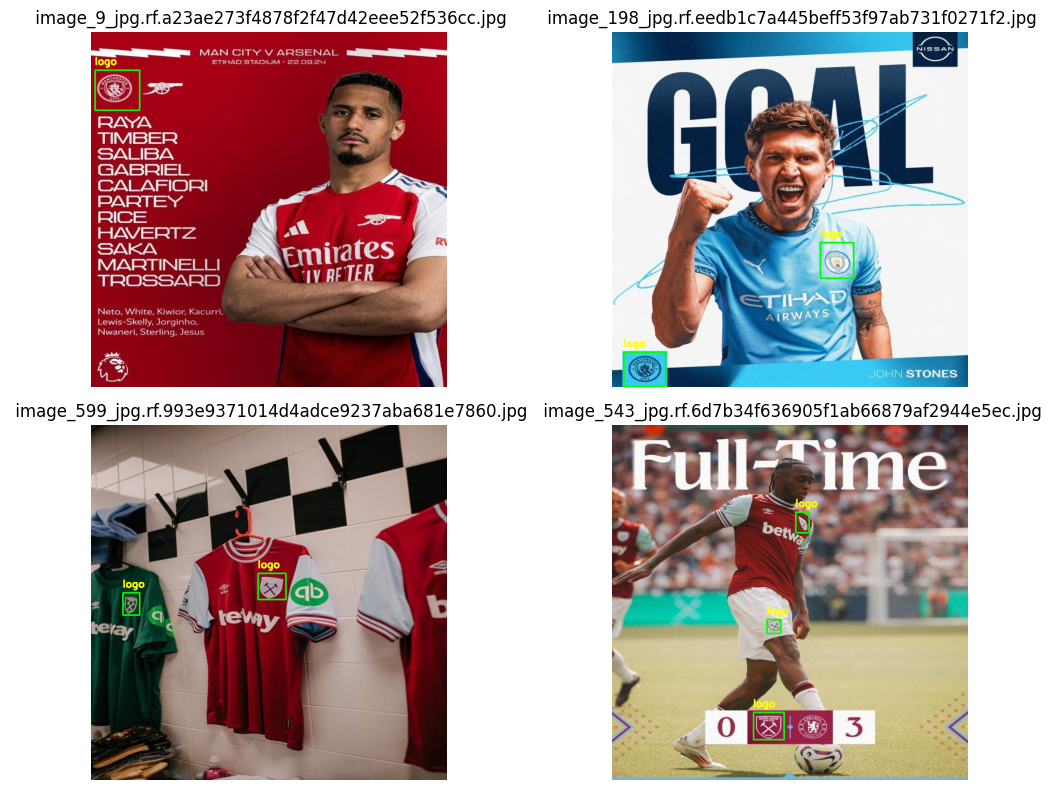

In [18]:
# Caminhos
train_img_dir = os.path.join(YOLO_DATASET_PATH, "train", "images")
train_lbl_dir = os.path.join(YOLO_DATASET_PATH, "train", "labels")

# Função para ler bounding boxes do formato YOLO
def read_yolo_labels(label_path):
    with open(label_path, 'r') as f:
        lines = f.readlines()
    boxes = []
    for line in lines:
        cls, x, y, w, h = map(float, line.strip().split())
        boxes.append((cls, x, y, w, h))
    return boxes

# Função para desenhar boxes
def draw_boxes(img_path, label_path):
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    h, w, _ = image.shape
    boxes = read_yolo_labels(label_path)

    for cls, x, y, bw, bh in boxes:
        x1 = int((x - bw / 2) * w)
        y1 = int((y - bh / 2) * h)
        x2 = int((x + bw / 2) * w)
        y2 = int((y + bh / 2) * h)
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(image, f"logo", (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 0), 2)
    
    return image

# Escolher imagens aleatórias
samples = random.sample(os.listdir(train_img_dir), 4)
plt.figure(figsize=(12, 8))
for idx, sample in enumerate(samples):
    img_path = os.path.join(train_img_dir, sample)
    label_path = os.path.join(train_lbl_dir, sample.replace('.jpg', '.txt').replace('.png', '.txt'))
    annotated_img = draw_boxes(img_path, label_path)
    plt.subplot(2, 2, idx+1)
    plt.imshow(annotated_img)
    plt.title(f" {sample}")
    plt.axis('off')
plt.tight_layout()
plt.show()


### ⚽🎯 Treino do YOLOv8 — Detetor de Emblemas

In [ ]:
# Inicializar modelo base YOLOv8
model = YOLO("yolov8n.pt")

# Caminho para o ficheiro data.yaml (já gerado pelo Roboflow)
yaml_path = os.path.join(YOLO_DATASET_PATH, "data.yaml")

# Treinar modelo YOLO
model.train(
    data=yaml_path,
    epochs=50,
    imgsz=640,
    batch=16,
    project="runs_yolo",
    name="logo_detector",
    val=True,
    exist_ok=True  
)

In [122]:
model = YOLO("runs_yolo/logo_detector/weights/best.pt")
print(model.names)

{0: 'logo'}


### 🧠📸 Inferência com o YOLOv8 — Deteção de Emblemas em Imagens 



image 1/1 /Users/pedrofs/Library/CloudStorage/OneDrive-ISCTE-IUL/Mestrado/2ªSem/APVC/Projeto/dataset/yolo-kit-dataset-final/liga-betclic/sporting-cp/sporting-cp.jpg: 640x640 1 logo, 38.3ms
Speed: 1.6ms preprocess, 38.3ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)
1 emblemas detetados.


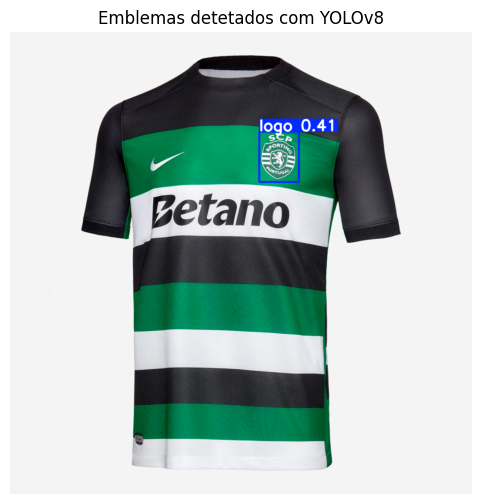

In [28]:
# Carregar o modelo YOLO treinado
detector = YOLO(YOLO_MODEL_PATH)

# Abrir janela para escolher imagem
root = tk.Tk()
root.withdraw()  # Esconde a janela principal

# Diretoria inicial
initial_dir = "/Users/pedrofs/Library/CloudStorage/OneDrive-ISCTE-IUL/Mestrado/2ªSem/APVC/Projeto/dataset/yolo-kit-dataset-final"

# File chooser
test_image_path = filedialog.askopenfilename(
    initialdir=initial_dir,
    title="Escolhe a imagem para testar",
    filetypes=[("Imagens", "*.jpg *.jpeg *.png")]
)

if not test_image_path:
    print("Nenhuma imagem selecionada. A sair...")
else:
    # Inferência com YOLO
    results = detector(test_image_path, conf=0.3)

    # Verificar se houve alguma deteção
    if results[0].boxes is not None and len(results[0].boxes) > 0:
        print(f"{len(results[0].boxes)} emblemas detetados.")
        output_image = results[0].plot()
        output_image = cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(10, 6))
        plt.imshow(output_image)
        plt.axis('off')
        plt.title("Emblemas detetados com YOLOv8")
        plt.show()
    else:
        print("Nenhuma deteção encontrada — verificar confiança, qualidade ou treino.")


### Apenas para teste - shrink e expand aos recortes do Yolo e depois classificar

>O notebook **yolo_com_cnn.ipynb** vai explorar mais o pipeline este bloco foi só para testar

In [213]:
# Testar com shrink e expand
from torchvision import transforms
from PIL import Image

# Hiperparâmetros
factors = {"shrink": 0.88, "expand": 1.3}
min_size = 40

# Transformações da CNN
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])

# Abrir imagem
image = Image.open(test_image_path).convert("RGB")
image_w, image_h = image.size

# Coordenadas da primeira box
cx, cy, bw, bh = results[0].boxes.xywh[0]

for mode, factor in factors.items():
    bw_adj, bh_adj = bw * factor, bh * factor

    if bw_adj < min_size or bh_adj < min_size:
        print(f"Box demasiado pequena ({mode}), ignorada.")
        continue

    x1 = int((cx - bw_adj / 2).item())
    y1 = int((cy - bh_adj / 2).item())
    x2 = int((cx + bw_adj / 2).item())
    y2 = int((cy + bh_adj / 2).item())

    x1, y1 = max(x1, 0), max(y1, 0)
    x2, y2 = min(x2, image_w), min(y2, image_h)

    cropped = image.crop((x1, y1, x2, y2))
    input_tensor = transform(cropped).unsqueeze(0).to(DEVICE)

    # CNN inferência
    with torch.no_grad():
        output = cnn(input_tensor)
        pred_idx = torch.argmax(output, dim=1).item()
        pred_clube = class_names[pred_idx]

    # Mostrar resultados
    print(f"\nModo: {mode}")
    print(f"Predição: {pred_clube}")
    cropped.show(title=f"{mode.upper()} Crop — {pred_clube}")



Modo: shrink
Predição: sporting-cp

Modo: expand
Predição: sporting-cp
